In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

from tensorflow.keras.models import load_model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

import numpy as np
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

<h2> File path for train,test and validation dataset</h2>

In [128]:
train_path= './Potato Head Results/train/'
test_path='./Potato Head Results/test/'
valid_path='./Potato Head Results/valid/'

<h2> Using Mobilnet's default prepocessing function to transform the dataset</h2>

In [129]:
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path,target_size=(224,224),batch_size=10)
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path,target_size=(224,224),batch_size=10)
validation_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(valid_path,target_size=(224,224),batch_size=10)

Found 215 images belonging to 5 classes.
Found 3093 images belonging to 5 classes.
Found 204 images belonging to 5 classes.


<h2>Mobile net Model call</h2>

In [130]:
mobile=tf.keras.applications.mobilenet.MobileNet()

In [131]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

<h2> Model Parameters</h2>

In [132]:
x=mobile.layers[-6].output
predictions = Dense(5,activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [133]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [134]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [135]:
model.compile(Adam(lr=.0001),loss ='categorical_crossentropy', metrics =['accuracy'])

<h2> Model Training</h2>

In [136]:
model.fit_generator(train_batches,steps_per_epoch=4,
                    validation_data=validation_batches, validation_steps=2,epochs=60,verbose=2)

Epoch 1/60
4/4 - 4s - loss: 1.9141 - accuracy: 0.3250 - val_loss: 2.3248 - val_accuracy: 0.2500
Epoch 2/60
4/4 - 1s - loss: 1.8272 - accuracy: 0.3250 - val_loss: 1.4138 - val_accuracy: 0.5000
Epoch 3/60
4/4 - 1s - loss: 1.6111 - accuracy: 0.3636 - val_loss: 1.8883 - val_accuracy: 0.2000
Epoch 4/60
4/4 - 1s - loss: 1.3116 - accuracy: 0.5500 - val_loss: 1.3433 - val_accuracy: 0.4500
Epoch 5/60
4/4 - 1s - loss: 1.4272 - accuracy: 0.4250 - val_loss: 1.4463 - val_accuracy: 0.3500
Epoch 6/60
4/4 - 1s - loss: 1.3974 - accuracy: 0.5000 - val_loss: 1.8951 - val_accuracy: 0.3000
Epoch 7/60
4/4 - 1s - loss: 1.2375 - accuracy: 0.4750 - val_loss: 1.8297 - val_accuracy: 0.4000
Epoch 8/60
4/4 - 1s - loss: 0.9225 - accuracy: 0.6750 - val_loss: 1.4436 - val_accuracy: 0.5000
Epoch 9/60
4/4 - 1s - loss: 0.9950 - accuracy: 0.6250 - val_loss: 1.4606 - val_accuracy: 0.5000
Epoch 10/60
4/4 - 1s - loss: 0.8709 - accuracy: 0.6250 - val_loss: 1.7581 - val_accuracy: 0.5000
Epoch 11/60
4/4 - 1s - loss: 0.9379 - a

<h2> Test Model</h2>

In [138]:
test_labels = test_batches.classes

In [140]:
test_labels.shape

(215,)

In [155]:
predictions=model.predict_generator(test_batches,steps=21,verbose=2)

21/21 - 2s


In [156]:
predictions.argmax(axis=1).shape

(210,)

In [157]:
cm=confusion_matrix(test_labels[:210],predictions.argmax(axis=1))

In [158]:
def plot_confusion_matrix(cm,classes,normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without Normalization')
    print(cm)
    
    thresh=cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [159]:
test_batches.class_indices

{'Angry': 0, 'Happy': 1, 'Neutral': 2, 'Sad': 3, 'Surprise': 4}

Confusion matrix without Normalization
[[ 5 20  5 19  5]
 [ 6 21 10 20  6]
 [ 5 17  5 16  2]
 [ 3  9  1 13  3]
 [ 0  7  2  6  4]]


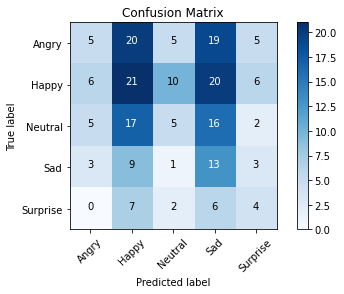

In [161]:
cm_plot_labels =['Angry','Happy','Neutral','Sad','Surprise']
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')